In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
#export
import math, k1lib, matplotlib.pyplot as plt, numpy as np
from itertools import accumulate

In [1]:
#export
def combine(lambdas:list, ratios:list=None) -> callable:
    """Combine multiple different schedules.
    Args:
        ratios: list[float], weighting diferent
            functions. Does not have to add up to 1.
        lambdas: list[callable], functions with 1 
            float input in [0, 1]"""
    if ratios == None: ratios = [1] * len(lambdas)
    ratios = np.array(ratios)
    ratios = ratios / ratios.sum()
    checkpoints = [0] + list(accumulate(ratios))
    def f(x):
        for idx, checkpoint in enumerate(checkpoints):
            if checkpoint > x: break
        a = checkpoints[idx - 1]
        return lambdas[idx - 1]((x - a)/(checkpoints[idx] - a))
    return f
def decorate(f:callable) -> callable:
    """Decorator, transforms f(low, high, x) to (low, high) -> f(x)."""
    def _f(low, high): return lambda x: f(low, high, x)
    _f.__doc__ = f.__doc__; return _f

In [4]:
#export
class ParamScheduler(k1lib.Callback):
    def __init__(self, param:str, schedule:callable): super().__init__(); self.param = param; self.schedule = schedule
    def startBatch(self):
        if self.model.training:
            for paramGroup in self.opt.param_groups: paramGroup[self.param] = self.schedule(self.progress)
    def _ipython_display_(self):
        print(f"'{self.param}' scheduler")
        x = np.linspace(0, 1, 1000); y = [self.schedule(x) for x in x]; plt.plot(x, y)

In [5]:
#export
@decorate
def linear(low, high, x): return low + x * (high - low)
@decorate
def cosine(low, high, x): return low + (high - low) * (1 + math.cos(math.pi * (1-x))) / 2
def oneCycle(low, high): return combine([cosine(0.8 * low + 0.2 * high, high), cosine(high, low)], [0.3, 0.7])
_en4 = math.e**-3
@decorate
def decay(low, high, x): return (math.exp(-x*4+1) - _en4) / (math.e - _en4) * (high - low) + low
def plateau(low, high): return decay(high, low)

In [6]:
!exportnb schedule.ipynb

'a' scheduler


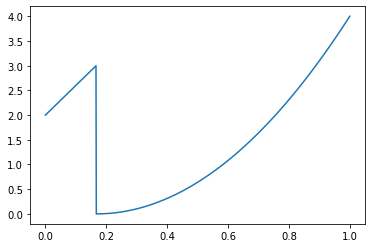

In [7]:
ParamScheduler("a", combine([lambda x: x+2, lambda x: (x*2)**2], [2, 10])) # vanilla

'lr' scheduler


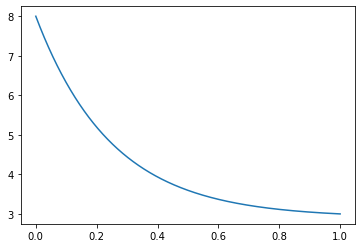

In [198]:
ParamScheduler("lr", decay(3, 8))

'lr' scheduler


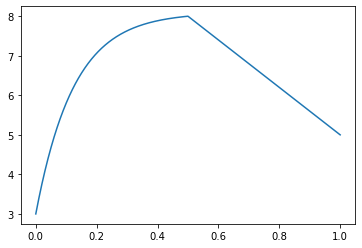

In [197]:
ParamScheduler("lr", combine([plateau(3, 8), linear(8, 5)]))

'lr' scheduler


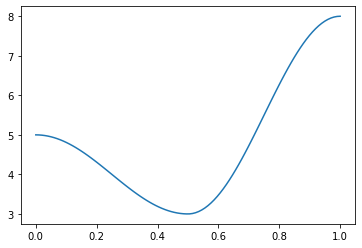

In [141]:
ParamScheduler("lr", combine([cosine(5, 3), cosine(3, 8)]))

'lr' scheduler


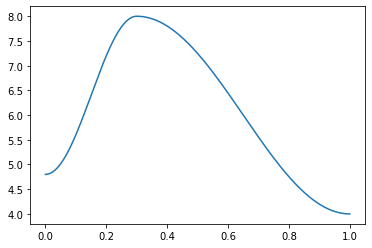

In [196]:
ParamScheduler("lr", oneCycle(4, 8))